# Parallel is All You Want: Combining Spatial and Temporal Feature Representions of Speech Emotion by Parallelizing CNNs and Transformer-Encoders
# Abstract
In this notebook, I'm going to build upon my [Intro to Speech Audio Classification repo](https://github.com/IliaZenkov/sklearn-audio-classification) and build two parallel convolutional neural networks (CNN) in parallel with a Transformer encoder network to classify audio data. We're working on the [RAVDESS dataset](https://smartlaboratory.org/ravdess/) to classify emotions from one of 8 classes. We combine the CNN for spatial feature representation and the Transformer for temporal feature representation. We augment the training data by increasing variation in the dataset to reduce overfitting; we use Additive White Gaussian Noise (AWGN) to augment the RAVDESS dataset three-fold for a total of 4320 audio samples.

We harness the image-classification and spatial feature representation power of the CNN by treating mel spectrograms as grayscale images; their width is a time scale, their height is a frequency scale. The value of each pixel in the mel spectrogram is the intensity of the audio signal at a particular mel frequency at a time step. 

Because of the sequential nature of the data, we will also use the Transformer to try and model as accurately as possible the temporal relationships between pitch transitions in emotions.  

This notebook takes inspirations from a variety of recent advances in deep learning and network architectures; in particular, stacked and parallel CNN networks combined with multi-head self-attention layers from the Transformer Encoder. I hypothesize that the expansion of CNN filter channel dimensions and reduction of feature maps will provide the most expressive feature representation at the lowest computational cost, while the Transformer-Encoder is used with the hypothesis that the network will learn to predict frequency distributions of different emotions according to the global structure of the mel spectrogram of each emotion. **With the strength of the CNN in spatial feature representation and Transformer in sequence encoding, I manage to achieve a 97% accuracy on a hold-out set from the RAVDESS dataset.**

<!--TABLE OF CONTENTS-->
# Table of Contents
- [Introduction](#Introduction)
  - [Define features](#Define-features)
  - [Load Data and Extract Features](#Load-Data-and-Extract-Features)
  - [Augmenting the Data with AWGN: Additive White Gaussian Noise](#Augmenting-the-Data-with-AWGN---Additive-White-Gaussian-Noise)
  - [Format Data into Tensor-Ready 4D Arrays](#Format-Data-into-Tensor-Ready-4D-Arrays)
  - [Split into Train/Validation/Test Sets](#Split-into-Train/Validation/Test-Sets)
  - [Feature Scaling](#Feature-Scaling)
- [Architecture Overview](#Architecture-Overview)
- [CNN Motivation](#CNN-Motivation)
- [Transformer-Encoder Motivation](#Transformer-Encoder-Motivation)
- [Building Model Architecture and Forward Pass](#Build-Model-Architecture-and-Define-Forward-Pass)
  - [Analyzing The Flow of Tensors Through the Network](#Analyzing-The-Flow-of-Tensors-Through-the-Network)
  - [Choosing Loss Function](#Define-Loss/Criterion)
  - [Choosing Optimizer](#Choose-Optimizer)
  - [Build Training Step](#Define-Training-Step)
  - [Build Validation Step](#Define-Validation-Step)
  - [Make Checkpoint Functions](#Make-Checkpoint-Functions)
- [Build Training Loop](#Build-Training-Loop)
  - [Train Model](#Train-It)
- [Check the Loss Curve's Behaviour](#Check-the-Loss-Curve's-Behaviour)
- [Evaluate Performance on Test Set](#Evaluate-Performance-on-Test-Set)
- [Conclusion](#Conclusion)
- [References](#References)

# Appendices
- [Appendix A: Convolutional Neural Nets Dissected](#Appendix-A---Convolutional-Neural-Nets-Dissected)
  - [Kernels and Filters](#Kernels-and-Filters)
  - [Zero Padding](#Zero-Padding)
  - [Max Pooling](#Max-Pooling)
  - [Regularization Using Dropout and a note on Pruning](#Regularization-Using-Dropout-and-a-note-on-Pruning)
  - [Batch Normalization and Optimizing the Optimization Landsape](#Batch-Normalization-and-Optimizing-the-Optimization-Landsape)
  - [ReLU: Non-Saturated Activations are Healthier (for CNNs)](#ReLU---Non-Saturated-Activations-are-Healthier-[for-CNNs])
  - [Turning Feature Maps into Probabilities with a Fully Connected Layer](#Turning-Feature-Maps-into-Probabilities-with-a-Fully-Connected-Layer)
- [Appendix B: The Transformer](#Appendix-B---The-Transformer)
    - [Self-Attention](#Self-Attention)
    - [Multi-Head Self-Attention](#Multi-Head-Self-Attention)
    - [Transformer Architecture](#Transformer-Architecture)
        - [Input](#Input)
        - [Encoder](#Encoder)
        - [Decoder](#Decoder)
        - [Output](#Output)
- [Appendix C: From Autoencoders to LSTMs to Attention](#Appendix-C---From-Autoencoders-to-LSTMs-to-Attention)
  - [Autoencoders](#Autoencoders)
  - [The Sparse Autoencoder](#The-Sparse-Autoencoder)
  - [The Variational Autoencoder, Decoders, and Latent Space](#The-Variational-Autoencoder,-Decoders,-and-Latent-Space)
  - [The RNN, Seq2Seq, and Gradient Problems](#The-RNN,-Seq2Seq,-and-Gradient-Problems)
  - [The LSTM Cell](#The-LSTM-Cell)
  - [Bidirectional RNN](#Bidirectional-RNN)
  - [The Attention Mechanism](#The-Attention-Mechanism)
- [Appendix D: Supplementary Notes](#Appendix-D---Supplementary-Notes)
  - [More CNN Kernel/Filter Math](#More-CNN-Kernel/Filter-Math)
  - [Smoothing the Optimization Surface](#Smoothing-the-Optimization-Surface)


# Introduction
From my previous notebook: "Long-Short-Term-Memory Recurrent Neural Networks (LSTM RNNs) and Convolutional Neural Networks (CNNs) are excellent DNN candidates for audio data classification: LSTM RNNs because of their excellent ability to interpret sequential data such as features of the audio waveform represented as a time series; CNNs because features engineered on audio data such as spectrograms have marked resemblance to images, in which CNNs excel at recognizing and discriminating between distinct patterns." - Me 

I'm going to build on that - CNNs are still the hallmark of image classification today, although even in this domain Transformers are beginning to take the main stage: A [2021 ICLR submission: An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://openreview.net/forum?id=YicbFdNTTy) claims they've implemented a Transformer for image classification that outperforms a state of the art CNN, and at a much lower computational complexity.

In addition to taking inspiration from the above, it's also no longer 2015 - so instead of the LSTM-RNN I'm going to implement its successor the Transformer model in parallel with a CNN to try and get state-of-the-art performance on the RAVDESS dataset. 

Other motivations for the architecture of this model come from a variety of papers from the past few years. **The most notable inspirations are:**
- The Transformer: [Attention is All You Need](https://arxiv.org/abs/1706.03762) for the Transformer
- Inception and GoogLeNet: [Going Deeper with Convolutions](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/43022.pdf) for parallel, stacked CNNs
- AlexNet: [ImageNet Classification with Deep Convolutional
](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) for increasing the complexity of feature maps with deeper CNN networks, as well as data augmentation by adding modified versions of the training data to itself
- VGGNet: [Very Deep Convolutional Networks For Large-Scale Image Recognition](https://arxiv.org/pdf/1409.1556.pdf) for using fixed size kernels throughout stacked CNN layers
- LeNet: [Gradient-Based Learning Applied to Document Recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf) for the convolution>pool>convolution>pool paradigm
- Self-Attention: [Long Short-Term Memory-Networks for Machine Reading](https://arxiv.org/pdf/1601.06733.pdf) for understanding Transformer architecture
- Dropout regularization: [Dropout: A Simple Way to Prevent Neural Networks from
Overfitting](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) speaks for itself
- Batch Norm: [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167) speaks for itself

Let's get to it.

#### Setup

In [7]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, glob
import librosa
import librosa.display
import IPython
from IPython.display import Audio
from IPython.display import Image
import warnings; warnings.filterwarnings('ignore') #matplot lib complains about librosa

In [ ]:
#google colab has an old version of librosa with missing mel spectrogram args; upgrade to current
!pip install -U librosa 

In [ ]:
# needed to import dataset from google drive into colab 
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Define features

Define features as in the previous notebook on this task from my ['sklearn-audio-classification' repo](https://github.com/IliaZenkov/sklearn-audio-classification). That notebook explains the motivation behind the Mel Spectrogram - in short, we're looking for transitions in audible pitch frequencies. 

**We're doing away with the chromagram and MFCCs - with this model Mel Spectrograms to provide as good an accuracy as using all three, and we don't want extra complexity in a highly parameterized deep neural net such as this one** where we don't absolutely need it.



In [10]:
# RAVDESS native sample rate is 48k
sample_rate = 48000

def feature_melspectrogram(
    waveform, 
    sample_rate,
    fft = 1024,
    winlen = 512,
    window='hamming',
    hop=256,
    mels=128,
    ):
    
    # Produce the mel spectrogram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # Using 8khz as upper frequency bound should be enough for most speech classification tasks
    melspectrogram = librosa.feature.melspectrogram(
        y=waveform, 
        sr=sample_rate, 
        n_fft=fft, 
        win_length=winlen, 
        window=window, 
        hop_length=hop, 
        n_mels=mels, 
        fmax=sample_rate/2)
    
    # convert from power (amplitude**2) to decibels
    melspectrogram = librosa.power_to_db(melspectrogram, ref=np.max)
    
    return melspectrogram

def get_features(file):
    
    # load an individual sample audio file
    # read the full 3 seconds of the file, cut off the first 0.5s of silence; native sample rate = 48k
    # don't need to store the sample rate that librosa.load returns
    waveform, _ = librosa.load(file, duration=3, offset=0.5, sr=sample_rate)
    
    # make sure waveform vectors are homogenous by defining explicitly
    waveform_homo = np.zeros((int(sample_rate*3,)))
    waveform_homo[:len(waveform)] = waveform
    
    # compute spectrogram features from audio waveform                                      
    melspectrogram = feature_melspectrogram(waveform_homo, sample_rate)

    return melspectrogram, waveform_homo
    
# RAVDESS dataset emotions
# shift emotions left to be 0 indexed for PyTorch
emotions_dict ={
    '0':'surprised',
    '1':'neutral',
    '2':'calm',
    '3':'happy',
    '4':'sad',
    '5':'angry',
    '6':'fearful',
    '7':'disgust'
}

# Additional attributes from RAVDESS to play with
emotion_attributes = {
    '01': 'normal',
    '02': 'strong'
}

## Load Data and Extract Features

We process each file in the dataset and extract its features.

We return the features and the labels (from the file names of the RAVDESS audio samples). We also return the raw waveforms because we're going to do some extra processing.

In [ ]:
import os, glob

# base path to all files in dataset
data_path = "/content/gdrive/My Drive/DL/RAVDESS/Actor_*/*.wav"

def load_data():
    # features and labels
    X,y=[],[]
    # raw waveforms to augment later
    waveforms = []
    # extra labels
    y_intensity, y_gender = [],[]
    # progress counter
    file_count = 0
    
    for file in glob.glob(data_path):
        # get file name with labels
        file_name = os.path.basename(file)
        
        # get emotion label from the sample's file
        emotion = int(file_name.split("-")[2])
        #  move surprise to 0 for better behaviour with 0 indexing
        if emotion == 8: emotion = 0 # surprise is now at 0 index; other emotion indeces unchanged
        # convert emotion label to emotion string if desired
        # training on number is better; better convert to emotion string after predictions are ready
        #emotion = emotions_dict[str(emotion)]
        
        # get other labels we might want
        intensity = emotion_attributes[file_name.split("-")[3]]
        if (int((file_name.split("-")[6]).split(".")[0]))%2==0: 
            gender = 'female' 
        else: 
            gender = 'male'
            
        # extract features form the sample
        features, waveform = get_features(file)
        
        # store waveforms to augment 
        waveforms.append(waveform)
        
        # store features and data
        X.append(features)
        y.append(emotion)
        y_intensity.append(intensity) # store intensity in case we wish to predict
        y_gender.append(gender) # store gender in case we wish to predict 
        
        file_count += 1
        # keep track of data loader's progress
        print('\r'+f' Processed {file_count}/{1440} audio samples',end='')

    return X, waveforms, y, np.array(y_intensity), np.array(y_gender)

In [ ]:
features, waveforms, emotions, intensities, genders = load_data()

 Processed 1440/1440 audio samples

## Check extracted features and data:

In [ ]:
print(f'Features set: {len(features)} samples')
print(f'Features (mel spectrogram) shape: {len(features[0])} mels x {len(features[0][1])} time steps')
print(f'Waveforms set: {len(waveforms)} samples')
# we have 1440 waveforms but we need to know their length too; should be 3 sec * 48k = 144k
print(f'Waveform signal length: {len(waveforms[0])}')
print(f'Emotions set: {len(emotions)} labels')

print('\nExtra data:')
print(f'Emotion intensity set: {intensities.shape[0]} labels')
print(f'Actor gender set: {genders.shape[0]} labels')

Features set: 1440 samples
Features (mel spectrogram) shape: 128 mels x 563 time steps
Waveforms set: 1440 samples
Waveform signal length: 144000
Emotions set: 1440 labels

Extra data:
Emotion intensity set: 1440 labels
Actor gender set: 1440 labels


Looks good. 1440 samples, 1440 sets of features and 1440 labels.

**Waveforms are 144k long because 3 seconds * 48k sample rate = 144k length array representing the 3 second audio snippet.**

## Augmenting the Data with AWGN - Additive White Gaussian Noise

### Motivation

Since our dataset is small, it is prone to overfitting - especially with highly parameterized deep neural net models
such as the one we aim to build in this notebook. As such, we're going to want to augment our data. Generating more real samples will be immensely difficult. Instead, we can add white noise to the audio signals - not only to mask the effect of random noise present in the training set - but also **to create pseudo-new training samples and offset the impact of noise intrinsic to the dataset.** 

In addition, the RAVDESS dataset is extremely clean - we will likely want to make predictions on noisy, real-world data - yet another reason to augment the training data.

We're going to use Additive White Gaussian Noise (AWGN). It's Additive because we're adding it to the source audio signal,
**it's Gaussian because the noise vector will be sampled from a normal distribution and have a time average of zero (zero-mean), and it's white because after a whitening transformation the noise will add power to the audio signal uniformly across the frequency distribution.**

We need a good balance of noise - too little will be useless, and too much will make it too difficult for the network to learn from the training data. **Note that this is just for training - we would _not_ need to add AWGN to real-world data on which we make predictions** (although we could). 

### Math
The key parameters in AWGN are the signal to noise ratio (SNR), defining the magnitude of the noise added w.r.t. the audio signal. We parameterize AWGN with the minimum and maximize SNR so we can pick a random SNR to use in augmenting each sample's waveform.

We need to constrain covariance to make it true AWGN. **We make a zero-mean vector of Gaussian noises (np.random.normal) that are statistically dependent. We need to apply a [whitening transformation](https://en.wikipedia.org/wiki/Whitening_transformation)**, a linear transformation taking a vector of random normal (Gaussian) variables with a known covariance matrix and mapping it to a new vector whose covariance is the identity matrix, i.e. the vector is now perfectly uncorrelated with a diaganol covariance matrix, each point of noise having variance == stdev == 1. **The whitening transformation by definition transforms a vector into a white noise vector.**

We're going to add the AWGN augmented waveforms as new samples to our dataset. **Since we generate AWGN which is random for each and every sample - random random noise - we can add multiples of our noise-augmented dataset. I'll add 2 extra identical, randomly noisy datasets with 1440 samples each to get a dataset with 1440 native + 1440x2 == 4320 noisy samples.**

In [ ]:
def awgn_augmentation(waveform, multiples=2, bits=16, snr_min=15, snr_max=30): 
    
    # get length of waveform (should be 3*48k = 144k)
    wave_len = len(waveform)
    
    # Generate two normally distributed (Gaussian) noises
    noise = np.random.normal(size=(multiples, wave_len))
    
    # Normalize waveform and noise
    norm_constant = 2.0**(bits-1)
    norm_wave = waveform / norm_constant
    norm_noise = noise / norm_constant
    
    # Compute power of waveform and power of noise
    signal_power = np.sum(norm_wave ** 2) / wave_len
    noise_power = np.sum(norm_noise ** 2, axis=1) / wave_len
    
    # Choose random SNR in decibels in range [15,30]
    snr = np.random.randint(snr_min, snr_max)
    
    # Apply whitening transformation: make the Gaussian noise into Gaussian white noise
    # Compute the covariance matrix used to whiten each noise 
    # actual SNR = signal/noise (power)
    # actual noise power = 10**(-snr/10)
    covariance = np.sqrt((signal_power / noise_power) * 10 ** (- snr / 10))
    # Get covariance matrix with dim: (144000, 2) so we can transform 2 noises: dim (2, 144000)
    covariance = np.ones((wave_len, multiples)) * covariance

    # Take Haddamard product of covariance and noise to generate white noise
    # Since covariance and noise are arrays, * is the haddamard product 
    multiple_augmented_waveforms = waveform + covariance.T * noise
    
    return multiple_augmented_waveforms

### Compute and add the AWGN-augmented audio samples to the rest of the dataset:

In [ ]:
# keep track of how many waveforms we've processed so we can add correct emotion label in the same order
emotion_count = 0
# keep track of how many augmented samples we've added
added_count = 0

# specify multiples of our dataaset to add as augmented data
multiples = 2

for waveform in waveforms:
    
    # Generate 2 augmented multiples of the dataset, i.e. 1440 native + 1440*2 noisy = 4320 samples total
    augmented_waveforms = awgn_augmentation(waveform, multiples=multiples)
    
    # compute spectrogram for each of 2 augmented waveforms
    for augmented_waveform in augmented_waveforms:
        
        # Compute augmented mel spectrogram
        augmented_melspectrogram = feature_melspectrogram(augmented_waveform, sample_rate=sample_rate)

        # append the augmented spectrogram to the rest of the native data
        features.append(augmented_melspectrogram)
        emotions.append(emotions[emotion_count])
        
        # keep track of new augmented samples
        added_count += 1
        
        # check progress
        print('\r'+f'Processed {emotion_count + 1}/{len(waveforms)} waveforms for {added_count}/{len(waveforms)*multiples} new augmented samples',end='')
        
    # keep track of the emotion labels to append in order
    emotion_count += 1

Processed 1440/1440 waveforms for 2880/2880 new augmented samples

### Check new shape of extracted features and data:

In [ ]:
print(f'Native + Augmented Features set: {len(features)} samples')
print(f'Features (mel spectrogram) shape: {len(features[0])} mels x {len(features[0][1])} time steps')

Native + Augmented Features set: 4320 samples
Features (mel spectrogram) shape: 128 mels x 563 time steps


### Check Augmented Waveforms:

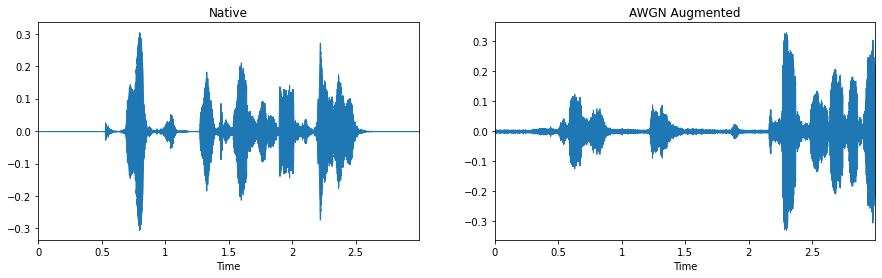

In [ ]:
plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
librosa.display.waveplot(waveforms[0], sr=sample_rate)
plt.title('Native')

plt.subplot(1, 2, 2)
librosa.display.waveplot(augmented_waveforms[0], sr=sample_rate)
plt.title('AWGN Augmented')
plt.show()

Looks noisy alright. Note that these aren't the same waveform (we have no need to store augmented waveforms; just need their features) so the augmented waveform is a random sample from the dataset. **We're just looking to see the noise, which is clearly visible in otherwise-silent regions of the waveform.**

## Format Data into Tensor Ready 4D Arrays
First stack the 4320-long list of 2D arrays (128x563 mel spectrograms) into a single 3D array.

We don't have a colour channel in our mel spectrogram feature array of dim (#samples, mel bands, time steps). **We have an analog of a black and white image: instead of 3 colour channels, we have 1 signal intensity channel: intensity of each of 128 mel frequency bands at time t.**

**We need an input channel dim to expand to output channels using CNN filters. We create a dummy channel dim to expand features into 2D-CNN-ready 4D tensor format: N x C x H x W.**

In [ ]:
# Stack the list of N 128x563 mel spectrograms into a single Nx128x563 3D array  
X = np.stack(features, axis=0)

# need to make dummy input channel for CNN input feature tensor
X = np.expand_dims(X,1)

# check we have tensor-ready 4D data array
# should print (batch, channel, width, height) == (4320, 1, 128, 563) with multiples==2
print('Shape of 4D feature array for input tensor: ',X.shape)

#free up some RAM - no longer need waveforms or individual spectrograms
del features, waveforms

Shape of 4D feature array for input tensor:  (4320, 1, 128, 563)


## Split into Train/Validation/Test Sets
We'll use an 80/10/10 train/validation/test split to maximize training data and keep a reasonable validation/test set. 

**Have to take care to split the sets proportionally w.r.t. emotion.**

**Have to be especially careful with augmented data that we don't train on validation or test sets by accident.**

In [ ]:
# create storage for train, validation, test sets and their indices
train_set,valid_set,test_set = [],[],[]
X_train,X_valid,X_test = [],[],[]
Y_train,Y_valid,Y_test = [],[],[]

# if we take the last 10% of 4320 samples, the last 
# 10% of 0-1440 and last 10% of 1440-2880 will be in the training and validation sets
# We need to process each batch of 1440 samples separately
# Taking 10% of each batch into the test set 
# This ensures test sets are true hold-out sets
for i in range(3):
    start_third = i * 1440
    stop_third = (i+1) * 1440
    for emotion_num in range(8):
        
        # indices of the current third of 4320 samples being processedd
        # find all indices of a single unique emotion
        #emotion_indices = np.where(emotions == emotions_dict[str(emotion)])[0]
        emotion_indices = [index+(start_third) for index, emotion in enumerate(emotions[start_third:stop_third]) if emotion==emotion_num]

        # shuffle indices so they're not in order of actor (or model might learn order of actors)
        emotion_indices = np.random.permutation(emotion_indices)

        # store dim (length) of the emotion list to make indices
        dim = len(emotion_indices)

        # store indices of training, validation and test sets in 80/10/10 proportion
        # train set is first 80%
        train_indices = emotion_indices[:int(0.8*dim)]
        # validation set is next 10% (between 80% and 90%)
        valid_indices = emotion_indices[int(0.8*dim):int(0.9*dim)]
        # test set is last 10% (between 90% - end/100%)
        test_indices = emotion_indices[int(0.9*dim):]
        ######take last 10% of each batch of 1440 for test set 

        # create train features/labels sets
        X_train.append(X[train_indices,:,:,:])
        Y_train.append(np.array([emotion_num]*len(train_indices),dtype=np.int32))
        # create validation features/labels sets
        X_valid.append(X[valid_indices,:,:,:])
        Y_valid.append(np.array([emotion_num]*len(valid_indices),dtype=np.int32))
        # create test features/labels sets
        X_test.append(X[test_indices,:,:,:])
        Y_test.append(np.array([emotion_num]*len(test_indices),dtype=np.int32))

        # store indices for each emotion set to verify uniqueness between sets 
        train_set.append(train_indices)
        valid_set.append(valid_indices)
        test_set.append(test_indices)


# concatenate in order all features back into one array 
X_train = np.concatenate(X_train,axis=0)
X_valid = np.concatenate(X_valid,axis=0)
X_test = np.concatenate(X_test,axis=0)

# concatenate in order all emotions back into one array 
Y_train = np.concatenate(Y_train,axis=0)
Y_valid = np.concatenate(Y_valid,axis=0)
Y_test = np.concatenate(Y_test,axis=0)

# combine and store indices for all emotions' train, validation, test sets to verify uniqueness of sets
train_set = np.concatenate(train_set,axis=0)
valid_set = np.concatenate(valid_set,axis=0)
test_set = np.concatenate(test_set,axis=0)

# check shape of each set
print(f' Y_train:{Y_train.shape}')
print(f'Y_valid:{Y_valid.shape}')
print(f' Y_test:{Y_test.shape}')

# make sure train, validation, test sets have no overlap/are unique:
uniques, index = np.unique(np.concatenate([train_set,test_set,valid_set],axis=0), return_counts=True)
if sum(index==1) == len(emotions):
    print(f'Sets are unique: {sum(index==1)} samples out of {len(emotions)} are unique')
else:
    print(f'Sets are NOT unique: {sum(index==1)} samples out of {len(emotions)} are unique')    

# free up some RAM - no longer need one set for all features (X) or emotion labels
del X, emotions

 Y_train:(3441,)
Y_valid:(429,)
 Y_test:(450,)
Sets are unique: 4320 samples out of 4320 are unique


## Feature Scaling
Standard Scaling makes the most sense because we have features whose target distribution we don't know. When I performed classification on this dataset with an MLP classifier standard scaling was best even when using just the mel spectrogram feature.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


# store shape so we can transform it back 
N,C,H,W = X_train.shape

#### Scale the training data ####
# Reshape to 1D StandardScaler operates on a 1D array
# tell numpy to infer shape of 1D array with -1 argument
X_train = np.reshape(X_train, (N,-1)) 
X_train = scaler.fit_transform(X_train)
# Transform back to NxCxHxW 4D tensor format
X_train = np.reshape(X_train, (N,C,H,W))

##### Scale the validation set ####
N,C,H,W = X_valid.shape
X_valid = np.reshape(X_valid, (N,-1))
X_valid = scaler.transform(X_valid)
X_valid = np.reshape(X_valid, (N,C,H,W))

#### Scale the test set ####
N,C,H,W = X_test.shape
X_test = np.reshape(X_test, (N,-1))
X_test = scaler.transform(X_test)
X_test = np.reshape(X_test, (N,C,H,W))

# check shape of each set again
print(f'X_train scaled:{X_train.shape}, Y_train:{Y_train.shape}')
print(f'X_valid scaled:{X_valid.shape}, Y_valid:{Y_valid.shape}')
print(f'X_test scaled:{X_test.shape}, Y_test:{Y_test.shape}')

X_train scaled:(3441, 1, 128, 563), Y_train:(3441,)
X_valid scaled:(429, 1, 128, 563), Y_valid:(429,)
X_test scaled:(450, 1, 128, 563), Y_test:(450,)


# Architecture Overview
<img src="reports/cnn-transformer-final.png">
As a whole, the CNN architecture of this network is inspired by a combination of the golden standards in image and sequence processing over the last few years.

Each 3-layer deep 2D convolutional block is extremely similar to the **classic [LeNet](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf) architecture: Conv->Pool>Conv>Pool>FC.** 

**[AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) forms the basis for increasing the complexity of feature maps with channel expansion through stacked CNN layers; [Inception and GoogLeNet](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/43022.pdf) are the inspiration for parallelizing CNN layers in the hopes of diverisfying the features learned by the network.** 

**[VGGNet](https://arxiv.org/pdf/1409.1556.pdf) proved the unreasonable efficiency of using fixed sized kernels throughout deeply stacked CNN layers;** I found this to extend to this task. Specifically, VGG saw an improvement over AlexNet largely by replacing large kernels (i.e. 11x11 stride 5) with smaller ones of 3x3 stride 1. One of the motivations that VGG cites for this is that the 3x3 kernel is the smallest kernel size choice in understanding spatial data w.r.t. up/down/left/right (although VGG also uses 1x1 kernels). VGGNet also inspires the maxpool kernel size of 2x2 stride 2, as I have used at the first layer of each convolutional block. 

To be more precise, the motivation to use small stacked filters is two-fold: Computational efficiency and expressivity of feature representation. When we stack 3 3x3 kernels on top of eachother as in this architecture, the second layer has a 5x5 view of the original input volume, and the 3rd layer a 7x7 view. However, the nonlinearities between each smaller layer convey more complex feature representations, whereas a single 7x7 layer would only perform a linear transformation itself. Furthermore, if we keep channel (C) consistent between layers, then 3 3x3 kernels are parameterized by (3(C(3x3xC)) = 27C^2 parameters, while just one 7x7 kernel needs C(7x7xC) = 49C^2 parameters. **Ultimately, small stacked kernels appear to be both more powerful and efficient - although, in [Large Kernel Matters -
Improve Semantic Segmentation by Global Convolutional Network](https://arxiv.org/pdf/1703.02719.pdf), the authors conclude that a larger kernel outperforms smaller stacked kernels for semantic segmentation - however, since we are just doing the semantic part (classification) and don't care about "where" the emotion is - this shouldn't apply.**

Finally, the original [2015 Batch Normalization (BN) paper](https://arxiv.org/abs/1502.03167) suggests that "We add the BN transform immediately before the nonlinearity" i.e. before ReLU; however, **I achieved better performance out of this architechture using BN after ReLU. See Keras author's [Francois Chollet's response on GitHub](https://github.com/keras-team/keras/issues/1802#issuecomment-187966878) regarding the BN order issue: "I can guarantee that recent code written by Christian \[Szegedy\] applies relu before BN".** 

The Transformer architecture is precisely as in Viswani et al, 2017: Attention is All You Need, but I use 4 stacked encoders instead of 6 as in their paper. For more details on the Transformer block: [Appendix B: The Transformer and Self-Attention (is All You Need)](#Appendix-B:-The-Transformer-and-Self-Attention-(is-All-You-Need))

# CNN Motivation
**CNNs with 2D convolutional layers are the gold standard for image processing**, other than the recent advances in the Transformer for images. 2D convolution layers accept input feature maps in a (N,C,H,W) (batch size, channel, height, width) format. We have 4320 mels - 1440 native and 2880 noise augmented - each mel is of shape 128x563 representing 128 mel frequency bands with 563 timesteps each. **We can imagine mel spectrograms to be a black and white image with 1 signal (colour) intensity channel.** Our mel spectrogram input feature tensor will thus be of shape (4320, 1, 128, 563). I'm going to refer to input/output feature maps and input/output volumes interchangeably, but they have the same meaning. After an activation function operates on a feature map, it produces an activation map.

I'm using 3x3 kernels in all 3 layers in both CNN blocks. The first layer only has a single input channel creating a 1x3x3 filter. The next layer has 16 input channels and 32 output channels , producing 32 unique 16x3x3 filters, *each* filter having 16x3x3 = 144 weights. The second layer is applying 32 differently weighted 16x3x3 filters to an input volume of 16x64x281 (the 2x2 maxpooled output of the first layer), producing an output feature map of 32x8x35 after 8x8 stride 8 maxpooling. The last layer has 32 input channels, so a 32x3x3 filter, and 64 output channels, so 64 unique such filters. The last layer produces an output feature map of 64x1x4 after 8x8 stride 4 maxpooling. **In sum, I hope that the expansion of filter dimensions and reduction of feature maps provides the most expressive feature representation at the lowest computational cost.** 

**The key motivations and operations of a 2D Convolutional Neural Net are described in detail in [Appendix A: Convolutional Neural Nets Dissected](#Appendix-A:-Convolutional-Neural-Nets-Dissected) in order to explain the motivation behind the necessity of the CNN for this task and the considerations to take when optimizing the hyperparameters of each layer in a CNN.**

# Transformer-Encoder Motivation

**I use the Transformer-Encoder layer as introduced in [Attention is All You Need](https://arxiv.org/abs/1706.03762) with the hopes that the network will learn to predict frequency distributions of different emotions according to the global structure of the mel spectrogram of each emotion.** I could have used LSTM-RNNs to learn the sequence of the spectrogram for each emotion, but the network would only learn to predict frequency changes according to adjacent time steps; in contrast, the multi-head self-attention layers of the transformer enable the network to look at multiple previous time steps when predicting the next. This made sense to me because emotions colour the entire sequence of frequencies, not just at one timestep. 

**The key motivations and operations behind the Transformer architecture are described in detail in [Appendix B: The Transformer](#Appendix-B:-The-Transformer)**

# Build Model Architecture and Define Forward Pass

In [8]:
#change nn.sequential to take dict to make more readable 

class parallel_all_you_want(nn.Module):
    # Define all layers present in the network
    def __init__(self,num_emotions):
        super().__init__() 
        
        ################ TRANSFORMER BLOCK #############################
        # maxpool the input feature map/tensor to the transformer 
        # a rectangular kernel worked better here for the rectangular input spectrogram feature map/tensor
        self.transformer_maxpool = nn.MaxPool2d(kernel_size=[2,4], stride=[2,4])
        
        # define single transformer encoder layer
        # self-attention + feedforward network from "Attention is All You Need" paper
        # 4 multi-head self-attention layers each with 64-->512--->64 feedforward network
        transformer_layer = nn.TransformerEncoderLayer(
            d_model=64, # input feature (frequency) dim after maxpooling 128*563 -> 64*140 (freq*time)
            nhead=4, # 4 self-attention layers in each multi-head self-attention layer in each encoder block
            dim_feedforward=512, # 2 linear layers in each encoder block's feedforward network: dim 64-->512--->64
            dropout=0.4, 
            activation='relu' # ReLU: avoid saturation/tame gradient/reduce compute time
        )
        
        # I'm using 4 instead of the 6 identical stacked encoder layrs used in Attention is All You Need paper
        # Complete transformer block contains 4 full transformer encoder layers (each w/ multihead self-attention+feedforward)
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=4)
        

        ############### 1ST PARALLEL 2D CONVOLUTION BLOCK ############
        # 3 sequential conv2D layers: (1,128,563) --> (16, 64, 281) -> (32, 8, 35) -> (64, 1, 4)
        self.conv2Dblock1 = nn.Sequential(
            
            # 1st 2D convolution layer
            nn.Conv2d(
                in_channels=1, # input volume depth == input channel dim == 1
                out_channels=16, # expand output feature map volume's depth to 16
                kernel_size=3, # typical 3*3 stride 1 kernel
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(16), # batch normalize the output feature map before activation
            nn.ReLU(), # feature map --> activation map
            nn.MaxPool2d(kernel_size=2, stride=2), #typical maxpool kernel size
            nn.Dropout(p=0.3), #randomly zero 30% of 1st layer's output feature map in training
            
            # 2nd 2D convolution layer identical to last except output dim, maxpool kernel
            nn.Conv2d(
                in_channels=16, 
                out_channels=32, # expand output feature map volume's depth to 32
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=8, stride=8), # increase maxpool kernel for subsequent filters
            nn.Dropout(p=0.3), 
            
            # 3rd 2D convolution layer identical to last except output dim
            nn.Conv2d(
                in_channels=32,
                out_channels=64, # expand output feature map volume's depth to 64
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=8, stride=8),
            nn.Dropout(p=0.3),
        )
        
        ############### 2ND PARALLEL 2D CONVOLUTION BLOCK ############
        # 3 sequential conv2D layers (1,128,563) --> (16, 64, 281) -> (32, 8, 35) -> (64, 1, 4)
        self.conv2Dblock2 = nn.Sequential(

            # 1st 2D convolution layer
            nn.Conv2d(
                in_channels=1, # input volume depth == input channel dim == 1
                out_channels=16, # expand output feature map volume's depth to 16
                kernel_size=3, # typical 3*3 stride 1 kernel
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(16), # batch normalize the output feature map before activation
            nn.ReLU(), # feature map --> activation map
            nn.MaxPool2d(kernel_size=2, stride=2), #typical maxpool kernel size
            nn.Dropout(p=0.3), #randomly zero 30% of 1st layer's output feature map in training

            # 2nd 2D convolution layer identical to last except output dim, maxpool kernel
            nn.Conv2d(
                in_channels=16, 
                out_channels=32, # expand output feature map volume's depth to 32
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=8, stride=8), # increase maxpool kernel for subsequent filters
            nn.Dropout(p=0.3), 

            # 3rd 2D convolution layer identical to last except output dim
            nn.Conv2d(
                in_channels=32,
                out_channels=64, # expand output feature map volume's depth to 64
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=8, stride=8),
            nn.Dropout(p=0.3),
        )
        
        ################# FINAL LINEAR BLOCK ####################
        # Linear softmax layer to take final concatenated embedding tensor 
        #    from parallel 2D convolutional and transformer blocks, output 8 logits 
        # Each full convolution block outputs (64*1*4) embedding flattened to dim 256 1D array 
        # Full transformer block outputs 64*140 feature map, then we time-avg to dim 64 1D array
        # 256*2+64 == 576 input features --> 8 output emotions 
        self.fc1_linear = nn.Linear(256*2 + 64,num_emotions) 
        
        # Softmax layer for the 8 output logits from final FC linear layer 
        self.softmax_out = nn.Softmax(dim=1) # dim==1 is the freq embedding
        
    # define one complete parallel fwd pass of input feature tensor thru 2*conv+1*transformer blocks
    def forward(self,x):
        
        ############ 1st parallel Conv2D block: 4 Convolutional layers ############################
        # create final feature embedding from 1st convolutional layer 
        # input features pased through 4 sequential 2D convolutional layers
        conv2d_embedding1 = self.conv2Dblock1(x) # x == N/batch * channel * freq * time
        
        # flatten final 64*1*4 feature map from convolutional layers to length 256 1D array 
        # skip the 1st (N/batch) dimension when flattening
        conv2d_embedding1 = torch.flatten(conv2d_embedding1, start_dim=1) 
        
        ############ 2nd parallel Conv2D block: 4 Convolutional layers #############################
        # create final feature embedding from 2nd convolutional layer 
        # input features pased through 4 sequential 2D convolutional layers
        conv2d_embedding2 = self.conv2Dblock2(x) # x == N/batch * channel * freq * time
        
        # flatten final 64*1*4 feature map from convolutional layers to length 256 1D array 
        # skip the 1st (N/batch) dimension when flattening
        conv2d_embedding2 = torch.flatten(conv2d_embedding2, start_dim=1) 
        
        
        ########## 4-encoder-layer Transformer block w/ 64-->512-->64 feedfwd network ##############
        # maxpool input feature map: 1*128*563 w/ 2*4 kernel --> 1*64*140
        x_maxpool = self.transformer_maxpool(x)
        # remove channel dim: 1*64*140 --> 64*140
        x_maxpool_reduced = torch.squeeze(x_maxpool,1)
        
        # convert maxpooled feature map format: batch * freq * time ---> time * batch * freq format
        # because transformer encoder layer requires tensor in format: time * batch * embedding (freq)
        x = x_maxpool_reduced.permute(2,0,1) 
        
        # finally, pass reduced input feature map x into transformer encoder layers
        transformer_output = self.transformer_encoder(x)
        
        # create final feature emedding from transformer layer by taking mean in the time dimension (now the 0th dim)
        # transformer outputs 64*140 (freq embedding*time) feature map, take mean of all columns i.e. take time average
        transformer_embedding = torch.mean(transformer_output, dim=0) # dim 64*140 --> 64
        
        ############# concatenate freq embeddings from convolutional and transformer blocks ######
        # concatenate embedding tensors output by parallel 2*conv and 1*transformer blocks
        complete_embedding = torch.cat([conv2d_embedding1, conv2d_embedding2, transformer_embedding], dim=1)  
       
        ######### final FC linear layer, need logits for loss #########################
        output_logits = self.fc1_linear(complete_embedding)  
        
        ######### Final Softmax layer: use logits from FC linear, get softmax for prediction ######
        output_softmax = self.softmax_out(output_logits)
        
        # need output logits to compute cross entropy loss, need softmax probabilities to predict class
        return output_logits, output_softmax                       

## Analyzing The Flow of Tensors Through the Network
We zero-pad 1 the input feature map to each convolutional layer to get back from the layer the same shape tensor as we input: zero-pad 1 adds 2 to each of (H, W) dims, and the 3x3, stride 1 kernels cuts off (kernel - stride == 2) dims from each of (H,W). **Zero-pad 1 --> 3x3 stride 1 kernel effectively throws away the zero pads to get same input/output shape from each conv2D block.**

At the end of first convolutional layer in each block we have a maxpool kernel of size 2x2, stride 2 which will take 1 of 4 pixels in its winddow. For the input feature map the maxpool kernel will progress 128/2 = 64 times over the rows and 563/2=281 times over the columns. **Nonoverlapping maxpool kernel reduces each output dim to input dim/kernel size.** We then expand the output channels to 16 making an output feature map of (16x64x281). 

The next two convolutional layers in each block have a maxpool kernel size 8x8, stride 8. Same math as above, maxpool reduces each dim/8. 2nd conv layer takes (16x64x281) --> (32x8x35). 3rd and final conv layer takes (32x8x35) --> (64x1x4).

**Note that in (N,C,H,W) format, for mel spectrograms H = mel frequency band,  W = time step.**

**Complete flow through each convolutional block (C,H,W):**

    Layer 1 ---> 1x128x563 --> PAD-1 --> 1x130x565 --> FILTER --> 16x128x563 --> MAXPOOL 2x2 stride 2 --> 16x64x281

    Layer 2 ---> 16x64x281 --> PAD-1 --> 16x66x283 --> FILTER --> 32x64x281 --> MAXPOOL 8x8 stride 8 --> 32x8x35

    Layer 3 ---> 32x8x35 --> PAD-1 --> 32x10x37 --> FILTER --> 64x8x35 --> MAXPOOL 8x8 stride 8 --> 64x1x4 

    Flatten ---> 64x1x4 --> Final convolutional embedding length 256 1D array


**Complete flow through transformer encoder block (C,H,W):**

    Maxpool 2x4 stride 2x4 ---> 1x128x563 --> 1x64x140

    Drop channel ---> 1x64x140 --> 64x140 (H,W)

    Change dims ---> 64x140 --> 140x64 (W,H)

    4*Transformer encoder ---> 140x64 --> 2x64 (W,H)

    Time average ---> 2x64 --> 1x64 --> Final transformer embedding length 64 1D array

**FC Linear network (C,H,W):**

    Concatenate ---> 256x256x64 --> 576 

    FC Linear layer ---> 576 --> Final linear logits output length 8 1D array

    Softmax layer: 8 ----> 1 predicted emotion / max probability class


We can confirm our network's tensor shapes and flow using the excellent torchsummary package which provides a PyTorch implementation of Keras' model.summary method:

In [ ]:
from torchsummary import summary

# need device to instantiate model
device = 'cuda'
# instantiate model for 8 emotions and move to CPU for summary
model = parallel_all_you_want(len(emotions_dict)).to(device)

# include input feature map dims in call to summary()
summary(model, input_size=(1,128,563))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 563]             160
       BatchNorm2d-2         [-1, 16, 128, 563]              32
              ReLU-3         [-1, 16, 128, 563]               0
         MaxPool2d-4          [-1, 16, 64, 281]               0
           Dropout-5          [-1, 16, 64, 281]               0
            Conv2d-6          [-1, 32, 64, 281]           4,640
       BatchNorm2d-7          [-1, 32, 64, 281]              64
              ReLU-8          [-1, 32, 64, 281]               0
         MaxPool2d-9            [-1, 32, 8, 35]               0
          Dropout-10            [-1, 32, 8, 35]               0
           Conv2d-11            [-1, 64, 8, 35]          18,496
      BatchNorm2d-12            [-1, 64, 8, 35]             128
             ReLU-13            [-1, 64, 8, 35]               0
        MaxPool2d-14             [-1, 6

## Define Loss/Criterion

We must define the loss function (criterion per PyTorch notation) for the backwards pass of each training iteration. Since our classes our balanced we don't need to specify a class-weight parameter (to balance classes).

**PyTorch nn.CrossEntropyLoss() implements log softmax and negative log likelihood loss (nn.NLLoss() --> nn.LogSoftmax())
We use log softmax for computation benefits and faster gradient optimization. Log softmax heavily penalizes the model when failing to predict the correct class.**

In [ ]:
# define loss function; CrossEntropyLoss() fairly standard for multiclass problems 
def criterion(predictions, targets): 
    return nn.CrossEntropyLoss()(input=predictions, target=targets)

## Choose Optimizer

I used Adam to train an MLP due to its faster compute and convergence. Adam is great and usually works well with defaults.

**However, a lot of 2018-2020 papers still use SGD. It seems to me that the reason is SGD with properly tuned momentum sometimes (often) converges to lower loss with enough training.**

**Quoting [Wilson et al, 2017](https://arxiv.org/abs/1705.08292):** 

    “We observe that the solutions found by adaptive methods generalize worse (often significantly worse) than SGD, even 
    when these solutions have better training performance. These results suggest that practitioners should reconsider the 
    use of adaptive methods to train neural networks."


"Adaptive methods" refers to the likes of Adam.
   
**I took full advantage of plain old SGD using the highest momentum I could while keeping this model easily trainable on Google Colab's free GPUs.**

In [ ]:
optimizer = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay=1e-3, momentum=0.8)

## Define Training Step

We define a function to return a single training step defining one iteration of our model.

    Forward pass output logits and softmax probabilities. 

    Record the softmax probabilities to track accuracy. 

    Pass output logits to loss function to compute loss.
    
    Call backwards pass with loss function (backpropogate errors).
    
    Tell optimizer to apply one update step to network parameters.
    
    Zero the accumulated gradient in the optimizer for next iteration.



In [ ]:
# define function to create a single step of the training phase
def make_train_step(model, criterion, optimizer):
    
    # define the training step of the training phase
    def train_step(X,Y):
        
        # forward pass
        output_logits, output_softmax = model(X)
        predictions = torch.argmax(output_softmax,dim=1)
        accuracy = torch.sum(Y==predictions)/float(len(Y))
        
        # compute loss on logits because nn.CrossEntropyLoss implements log softmax
        loss = criterion(output_logits, Y) 
        
        # compute gradients for the optimizer to use 
        loss.backward()
        
        # update network parameters based on gradient stored (by calling loss.backward())
        optimizer.step()
        
        # zero out gradients for next pass
        # pytorch accumulates gradients from backwards passes (convenient for RNNs)
        optimizer.zero_grad() 
        
        return loss.item(), accuracy*100
    return train_step

## Define Validation Step

Define a function to return a single validation step on the 10% X,y tensor pair to get an idea of our model's generalizibiliy as it trains so we know whether and when to stop it and tune hyperparameters. **Make sure we _do not_ update network parameters during validation by setting model to validation mode. Do not waste resources computing gradients in validation phase by setting torch.no_grad().**

In [ ]:
def make_validate_fnc(model,criterion):
    def validate(X,Y):
        
        # don't want to update any network parameters on validation passes: don't need gradient
        # wrap in torch.no_grad to save memory and compute in validation phase: 
        with torch.no_grad(): 
            
            # set model to validation phase i.e. turn off dropout and batchnorm layers 
            model.eval()
            
            # get the model's predictions on the validation set
            output_logits, output_softmax = model(X)
            predictions = torch.argmax(output_softmax,dim=1)
            
            # calculate the mean accuracy over the entire validation set
            accuracy = torch.sum(Y==predictions)/float(len(Y))
            
            # compute error from logits (nn.crossentropy implements softmax)
            loss = criterion(output_logits,Y)
            
        return loss.item(), accuracy*100, predictions
    return validate

# Make Checkpoint Functions
It's a good idea to save checkpoints of the model state after each epoch. We'll then interrupt training when satisfied with the model's performance and load the appropriate model binary. 

- Resume training if hardware/software fails
- Save compute re-training by training from checkpoint after tuning
- Implement early stopping easily by keeping snapshot of most performant version of model
- Google Colab throttles GPU usages eventually

In [ ]:
def make_save_checkpoint(): 
    def save_checkpoint(optimizer, model, epoch, filename):
        checkpoint_dict = {
            'optimizer': optimizer.state_dict(),
            'model': model.state_dict(),
            'epoch': epoch
        }
        torch.save(checkpoint_dict, filename)
    return save_checkpoint

def load_checkpoint(optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    epoch = checkpoint_dict['epoch']
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    return epoch

# Build Training Loop

Build the complete training loop using the training and validation step functions. 

This model is not reasonable to train on CPU, but it's a good way to check if the model compiled successfully. I'm using Google Colab's free GPU (K80 - 24GB RAM ~2.9 TFLOPs). This model is pretty big (383,688 params to learn if I've checked the math correctly) but trains to convergence within ~10 minutes on a K80.

Pick the number of epochs (complete pass of all training samples) to use that is higher than reasonable so the model does not terminate just before convergence - I manually stopped it when it converges. 

**Minibatch size:** [From Yann LeCun's twitter](https://twitter.com/ylecun/status/989610208497360896?lang=en) (with LeCun facebook comment appended) [citing this 2018 minibatch paper](https://arxiv.org/abs/1804.07612):

<i>
    
    "Training with large minibatches is bad for your health. More importantly, it's bad for your test error. Friends dont 
    let friends use minibatches larger than 32. Let's face it: the only people have switched to minibatch sizes larger than one since 2012 is because GPUs are inefficient for batch sizes smaller than 32. That's a terrible reason. It just means our hardware sucks." 
    
</i>

<br>
That's about it for the logic. Here's the full training loop:

    --Setup--
    
    Instantiate model.

    Instantiate training and validation steps with model, loss function, and optimizer. 
    
    Move model to GPU.
    
        --Epoch--
    
        Set model to train mode after each post-epoch validation phase completes.
    
        Shuffle the training set for each  epoch, reset epoch loss and accuracy. 
        
            --Iteration--
    
            Create X_train, y_train minibatch tensors for each iteration and move tensors to GPU.
            
            Take 1 train step with X_train, y_train minibatch tensors.

            Aggregate accuracy and loss from each iteration, but only record after each epoch. 
            
        --Epoch--

        Compute and record validation accuracy for the entire epoch to keep track of learning progress. 

        Print training metrics after each epoch.

In [ ]:
# get training set size to calculate # iterations and minibatch indices
train_size = X_train.shape[0]

# pick minibatch size (of 32... always)
minibatch = 32

# set device to GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'{device} selected')

# instantiate model and move to GPU for training
model = parallel_all_you_want(num_emotions=len(emotions_dict)).to(device) 
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()) )

# encountered bugs in google colab unless I explicitly defined optimizer in this cell...
optimizer = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay=1e-3, momentum=0.8)

# need to copy the checkpoint function over here too
save_checkpoint = make_save_checkpoint()

# instantiate the training step function 
train_step = make_train_step(model, criterion, optimizer=optimizer)

# instantiate the validation loop function
validate = make_validate_fnc(model,criterion)

# instantiate lists to hold scalar performance metrics to plot later
train_losses=[]
valid_losses = []

# create training loop for one complete epoch (entire training set)
def train(optimizer, model, num_epochs, X_train, Y_train, X_valid, Y_valid):

    for epoch in range(num_epochs):
        
        # set model to train phase
        model.train()         
        
        # shuffle entire training set in each epoch to randomize minibatch order
        ind = np.random.permutation(train_size) 
        
        # shuffle the training set for each epoch:
        X_train = X_train[ind,:,:,:] 
        Y_train = Y_train[ind]
        
        # instantiate scalar values to keep track of progress after each epoch so we can stop training when appropriate 
        epoch_acc = 0 
        epoch_loss = 0
        num_iterations = int(train_size / minibatch)
        
        # create a loop for each minibatch of 32 samples:
        for i in range(num_iterations):
            
            # we have to track and update minibatch position for the current minibatch
            # if we take a random batch position from a set, we almost certainly will skip some of the data in that set
            # track minibatch position based on iteration number:
            batch_start = i * minibatch 
            # ensure we don't go out of the bounds of our training set:
            batch_end = min(batch_start + minibatch, train_size) 
            # ensure we don't have an index error
            actual_batch_size = batch_end-batch_start 
            
            # get training minibatch with all channnels and 2D feature dims
            X = X_train[batch_start:batch_end,:,:,:] 
            # get training minibatch labels 
            Y = Y_train[batch_start:batch_end] 
            
            # instantiate training tensors
            X_tensor = torch.tensor(X, device=device).float() 
            Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)
            
            # Pass input tensors thru 1 training step (fwd+backwards pass)
            loss, acc = train_step(X_tensor,Y_tensor) 
            
            # aggregate batch accuracy to measure progress of entire epoch
            epoch_acc += acc * actual_batch_size / train_size
            epoch_loss += loss * actual_batch_size / train_size
            
            # keep track of the iteration to see if the model's too slow
            print('\r'+f'Epoch {epoch}: iteration {i}/{num_iterations}',end='')
        
        # create tensors from validation set
        X_valid_tensor = torch.tensor(X_valid,device=device).float()
        Y_valid_tensor = torch.tensor(Y_valid,dtype=torch.long,device=device)
        
        # calculate validation metrics to keep track of progress; don't need predictions now
        valid_loss, valid_acc, _ = validate(X_valid_tensor,Y_valid_tensor)
        
        # accumulate scalar performance metrics at each epoch to track and plot later
        train_losses.append(epoch_loss)
        valid_losses.append(valid_loss)
                  
        # Save checkpoint of the model
        checkpoint_filename = '/content/gdrive/My Drive/DL/models/checkpoints/parallel_all_you_want-{:03d}.pkl'.format(epoch)
        save_checkpoint(optimizer, model, epoch, checkpoint_filename)
        
        # keep track of each epoch's progress
        print(f'\nEpoch {epoch} --- loss:{epoch_loss:.3f}, Epoch accuracy:{epoch_acc:.2f}%, Validation loss:{valid_loss:.3f}, Validation accuracy:{valid_acc:.2f}%')


cuda selected
Number of trainable params:  383688


## Train It

In [ ]:
# choose number of epochs higher than reasonable so we can manually stop training 
num_epochs = 500

# train it!
train(optimizer, model, num_epochs, X_train, Y_train, X_valid, Y_valid)

Epoch 0: iteration 106/107
Epoch 0 --- loss:3.281, Epoch accuracy:22.46%, Validation loss:1.984, Validation accuracy:26.81%
Epoch 1: iteration 106/107
Epoch 1 --- loss:1.908, Epoch accuracy:31.27%, Validation loss:1.811, Validation accuracy:35.66%
Epoch 2: iteration 106/107
Epoch 2 --- loss:1.801, Epoch accuracy:33.71%, Validation loss:1.784, Validation accuracy:35.66%
Epoch 3: iteration 106/107
Epoch 3 --- loss:1.662, Epoch accuracy:38.71%, Validation loss:1.642, Validation accuracy:41.26%
Epoch 4: iteration 106/107
Epoch 4 --- loss:1.605, Epoch accuracy:40.60%, Validation loss:1.658, Validation accuracy:40.09%
Epoch 5: iteration 106/107
Epoch 5 --- loss:1.522, Epoch accuracy:43.42%, Validation loss:1.764, Validation accuracy:36.36%
Epoch 6: iteration 106/107
Epoch 6 --- loss:1.506, Epoch accuracy:43.30%, Validation loss:1.671, Validation accuracy:42.19%
Epoch 7: iteration 106/107
Epoch 7 --- loss:1.465, Epoch accuracy:45.10%, Validation loss:1.594, Validation accuracy:42.19%
Epoch 8:

KeyboardInterrupt: ignored

# Check the Loss Curve's Behaviour
Let's see if we missed something egregious during training. 

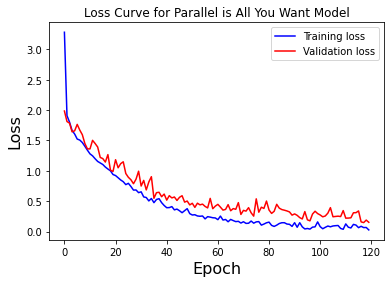

In [ ]:
plt.title('Loss Curve for Parallel is All You Want Model')
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.plot(train_losses[:120],'b')
plt.plot(valid_losses[:120],'r')
plt.legend(['Training loss','Validation loss'])

# Load the Trained Model from Checkpoint for Evaluation

In [1]:
# pick load folder  
load_folder = '/content/gdrive/My Drive/DL/models2'  
#load_folder = './models'

# pick the epoch to load
epoch = '119'
model_name = f'parallel_all_you_want-{epoch}.pkl'

# make full load path
load_path = os.path.join(load_folder, model_name)

## instantiate empty model and populate with params from binary 
model = parallel_all_you_want(len(emotions_dict))
load_checkpoint(optimizer, model, load_path)

print(f'Loaded model from {load_path}')

Loaded model from /content/gdrive/My Drive/DL/models/checkpoints/parallel_all_you_want-119.pkl


# Evaluate the Model on Hold-Out Test Set
Fingers crossed for generalizability.

In [ ]:
# Convert 4D test feature set array to tensor and move to GPU
X_test_tensor = torch.tensor(X_test,device=device).float()
# Convert 4D test label set array to tensor and move to GPU
Y_test_tensor = torch.tensor(Y_test,dtype=torch.long,device=device)

# Get the model's performance metrics using the validation function we defined
test_loss, test_acc, predicted_emotions = validate(X_test_tensor,Y_test_tensor)

print(f'Test accuracy is {test_acc:.2f}%')

Test accuracy is 97.11%


# Analyze Performance on Test Set

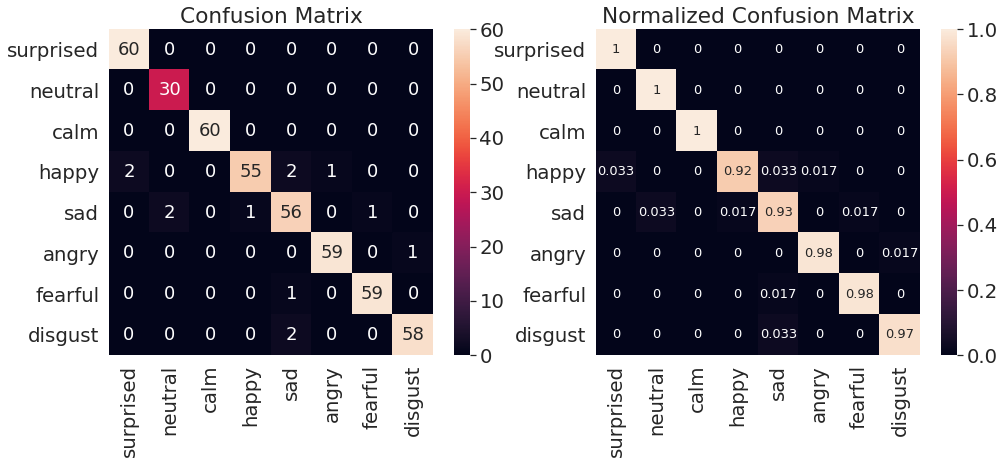

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

# because model tested on GPU, move prediction tensor to CPU then convert to array
predicted_emotions = predicted_emotions.cpu().numpy()
# use labels from test set
emotions_groundtruth = Y_test

# build confusion matrix and normalized confusion matrix
conf_matrix = confusion_matrix(emotions_groundtruth, predicted_emotions)
conf_matrix_norm = confusion_matrix(emotions_groundtruth, predicted_emotions,normalize='true')

# set labels for matrix axes from emotions
emotion_names = [emotion for emotion in emotions_dict.values()]

# make a confusion matrix with labels using a DataFrame
confmatrix_df = pd.DataFrame(conf_matrix, index=emotion_names, columns=emotion_names)
confmatrix_df_norm = pd.DataFrame(conf_matrix_norm, index=emotion_names, columns=emotion_names)

# plot confusion matrices
plt.figure(figsize=(16,6))
sn.set(font_scale=1.8) # emotion label and title size
plt.subplot(1,2,1)
plt.title('Confusion Matrix')
sn.heatmap(confmatrix_df, annot=True, annot_kws={"size": 18}) #annot_kws is value font
plt.subplot(1,2,2)
plt.title('Normalized Confusion Matrix')
sn.heatmap(confmatrix_df_norm, annot=True, annot_kws={"size": 13}) #annot_kws is value font

plt.show()

# Conclusion
---------------
Advances of the last 5 years involving upgrades to the autoencoder scheme have lead to the RNN, the upgraded LSTM-RNN, bidirectional LSTM-RNNs, and eventually to LSTM-RNNs with Attention layers to give profound temporal expressivity to the latent space of sequentially encoded data. The Transformer has built on this by taking advantage of parallelized self-attention layers to provide an almost truly global temporal representation of sequential data. 

Today, carefully thought out architecture building on these blocks leads to reasonable training times and excellent generalizability. We combine the CNN for spatial feature representation and the Transformer for temporal feature representation, and  augment the training data by increasing variation in the training dataset to reduce overfitting.

CNNs are still the standard for encoding representations of spatial data. A CNN's filters' kernel sizes are important to both performance and accuracy, especially considering recent paradigms using smaller maxpool kernels such as those of the 3x3 strided 1 kernels in [VGGNet](https://arxiv.org/pdf/1409.1556.pdf), in contrast to the 11x11 stride 4 kernels as in the [AlexNet paper](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf).

When we added convolutional and transformer layers beyond what was used here, that actually decreased test accuracy. Only as much complexity is warranted as is needed for generalizability. Although CNNs are good for images and transformers for sequential data, recently emerging paradigms (such as in this notebook) show that these networks are perfectly cross-applicable given careful thought. 

CNNs are powerful. Transformers work beautifully. They're even better together. Gone are the days of the LSTM-RNN.

If you got this far, I sincerely appreciate your taking the time to do so. Feel free to drop me a line at ilzenkov@gmail.com with any feedback or questions you may have.

# References 
--------------
- Ba et al, 2016. Layer Normalization. https://arxiv.org/abs/1607.06450
- Bahdanau et al, 2015. https://arxiv.org/pdf/1409.0473.pdf
- Cheng et al, 2016. Long Short-Term Memory-Networks for Machine Reading. https://arxiv.org/pdf/1601.06733.pdf
- He et al, 2015. Deep Residual Learning for Image Recognition. https://arxiv.org/abs/1512.03385
- Ioffe, Szegedy, 2015. Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift. https://arxiv.org/abs/1502.03167
- Krizhevsky et al, 2017. ImageNet Classification with Deep Convolutional Neural Networks. https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf
- LeCunn et al, 1998. Gradient-Based Learning Applied to Document Recognition. http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf
- Li et al, 2018. Visualizing the Loss Landscape of Neural Nets. https://papers.nips.cc/paper/7875-visualizing-the-loss-landscape-of-neural-nets.pdf
- Masters and Luschi, 2018. Revisiting Small Batch Training for Deep Neural Networks. https://arxiv.org/abs/1804.07612 
- Peng et al, 2017. Large Kernel Matters —— Improve Semantic Segmentation by Global Convolutional Network. https://arxiv.org/pdf/1703.02719.pdf
- Santurkar et al, 2019. How Does Batch Normalization Help Optimization? https://arxiv.org/pdf/1805.11604.pdf
- Simonyan and Zisserman, 2015. Very Deep Convolutional Networks for Large-Scale Image Recognition. https://arxiv.org/pdf/1409.1556.pdf
- Srivastava et al, 2014. Dropout: A Simple Way to Prevent Neural Networks from Overfitting. https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf
- Ulyanov et al, 2017. Instance Normalization: The Missing Ingredient for Fast Stylization. https://arxiv.org/pdf/1607.08022.pdf
- Vaswani et al, 2017. Attention Is All You Need. https://arxiv.org/abs/1706.03762
- Wilson et al, 2017. The Marginal Value of Adaptive Gradient Methods in Machine Learning. https://arxiv.org/abs/1705.08292

- Christopher Olah's Blog; Neural Networks, Types, and Functional Programming: http://colah.github.io/posts/2015-09-NN-Types-FP/
- Lilian Weng's blog on Attention Mechanisms: https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html
- Stanford Autoencoder tutorial: http://ufldl.stanford.edu/tutorial/unsupervised/Autoencoders/
- Stanford CNN Tutorial: http://ufldl.stanford.edu/tutorial/supervised/FeatureExtractionUsingConvolution/
- Stanford's CS231n: https://cs231n.github.io/convolutional-networks/
- U of T CSC2515, Optimization: https://www.cs.toronto.edu/~hinton/csc2515/notes/lec6tutorial.pdf


# Appendix A - Convolutional Neural Nets Dissected 
--------------------------------------
### [Back to main section: CNN Motivation](#CNN-Motivation)


## Kernels and Filters

At the heart of the behaviour of each convoluitional layer is its kernels. Each convolutional layer is made of a certain number of 2D kernels whose dimensions we specify .**A stack of 2D kernels in a layer create the 3D filters defining the operation of that layer on its input feature map (a tensor). Each filter contains a number of weights equal to its size (i.e. depth x height x width).** The kernel's size is a hyperparameter of the convolutional layer; the kernel's receptive field. It is so named because **the kernel's size determines the dimensions of the input feature map it sees during each convoluton.** 

**Even though complete CNN filters are 3D, they are only moved by their stride length in the H x W dimensions and encompass the entire depth of the feature map over which they operate - so the convolution is actually 2D, hence the nomenclature.**

<img src="img/convolutional layer stanford.gif" width=400 height=400 />
<center><sub>Visualization of a single 3x3 stride 1 kernel's convolution with a 5x5 feautre map. Figure from Stanford Deep Learning Tutorial: http://ufldl.stanford.edu/tutorial/supervised/FeatureExtractionUsingConvolution/
</sub></center>

When performing a convolution, we take the products of the kernel's weights with the values of the input feature map and sum them to create a single entry in the output feature map. In this task, the initial input feature map has values describing pixel brightness - in our case, **we have 128x563 "spectrogram pixels", each pixel representing the intensity in decibels of each of 128 mel frequencies at each of 563 time points - in other words, we have a 128x563 grayscale image map with just one channel for brightness, which is why a CNN is a first-choice model for the task.**  Each kernel constituting a convolutional layer's filter creates a single 2D feature map - and so **more kernels = larger filters = more 2D feature maps = higher complexity (depth) 3D feature maps, where the # of kernels is specified by a layer's input channel.** If our input feature map has 1 channel and 2D dimensions H x W and we want 16 output channels, we'll have 1 2D kernel in that layer's filter and produce 16 2D feature maps of H x W, or a single 3D 16 x H x W feature map for the entire layer. **A higher output channel dimension creates a larger quantity of output feature maps. This may be beneficial or detrimental w.r.t. overfitting depending on the task.**

For every input channel we have one 2D kernel, so when we have multiple input channels we have a collection of 2D kernels making up a 3D filter. Each 2D kernel creates a single 2D contribution to each output channel - so the entire 3D filter creates one entire 3D output channel. In this architecture, and as is standard for stacked CNNs, we expand the complexity of the input feature map in the channel/depth dimension while keeping constant its H x W dimensions. Each 3D filter is passed over the input feature map once for every complete output channel. The number of input channels determines the number of 2D kernels and thus, the *size of all 3D filters* in a layer, while the number of output channels determines *how many 3D filters* are passed over the input feature map - the convolution of all input feature maps with unique 3D filter creates one unique output channel. 

**To summarize, the input channel dimension determines the *size of all 3D filters* in that layer, while the output channel dimension determines the *number of unique 3D filters* in that layer. Each filter is defined by a unique set of weights, and each filter has its own bias term.**

<img src="img/filter weights.png" width=700 height=700 />
<center><sub>A collection of 2D kernels makes up a conolutional layer's 3D filters: each filter has a unique set of weights, visualized here. The Kernel size is FxF and Depth is C (Channel dimension). Figure from Stanford's CS230: https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks
</sub></center>

<img src="img/filter vis.png" width=400 height=400>
<center><sub>Visual of a 3-channel (RGB) 3D filter volume operating on a 3-channel 3D input volume to produce an output 3D volume - depth dependent on number of filters/output-channels of the conv layer.
</sub></center>

Each filter in a layer learns to produce a high-magnitude activation (after ReLU) when encountering a feature which it has learned to represent. Each filter outputs creates a unique feature map. In performant CNNs, the filters in each convolutional layer are likely to learn a different set of high-level features, in a hierarchical manner of increasing complexity with each subsequent convolutional layer as we expand the channel dimension. The idea behind this paradigm is to create higher-order feature representations akin to the way humans recognize images.

Touching on the neuron representation of a CNN, **every element of a 3D output volume can be seen as the activation of a neuron that looks at a small region in the input volume.** Every neuron in a filter shares parameters with all neurons to the left and right of it spatially because the parameters are updated for these neurons by applying that same filter. **In this way, the neurons of a CNN are only locally connected in contrast to the fully connected "dense" layer.**

**To be succint: A CNN layer transforms a 3D input volume to a 3D output volume of neuron activations. Classification itself is only done by subsequent non-convolutional layers, usually with fully connected linear layers.**
 
 
## Zero Padding

We zero pad the input feature map at the start of each convolutional block, i.e. add a column and row of zeroes to each side of the feature map's (H,W) dimension. **If we don't zero-pad before each convolutional layer then the input feature map is producing only 'valid' convolutions with the filters; after each full convolution the size of the output feature map would reduce by a small amount: The information at the borders will gradually erode.** If a kernel's next stride will set it to be out of bounds of the last column of the (H,W) dimensions of the feature map, that convolution would not be valid; the kernel will proceed (take a step of length==stride) down to the next row. If our kernel sizes is > 1 and stride length is > 1, this means we will completely lose features at the right and bottom edge of our feature map. Zero padding is standard in convolutional layers for kernel sizes > 1, even with a stride of 1 - if we don't pad in this case, corner pixels (features) will only be used once. **Because all convolutional kernels in this network are 3x3 stride 1; I zero-pad 1 to preserve the input dimensions of the feature map at each convolutional layer, i.e. 'same' zero-padding.**


## Max Pooling

This is where the real magic happens. Maxpool kernels operate on a feature map much like convolutional kernels; however, they perform no multiplication or addition, but rather a simple argmax operation taking the highest valued feature in the maxpool kernel's receptive field; In this way, maxpool layers reduce the dimensions of the feature maps (volumes) upon which they operate. Maxpooling can be equivalently seen as a dimensionality reduction, or down-sampling technique for features spaces. **Ultimately, maxpooling drastically reduces the numer of parameters a network must learn**; there are much fewer connections between subsequent layers than there would be without maxpooling. **Maxpooling is precisely what makes CNNs practical.** 

Intuitively, maxpooling outputs a feature map that contains only the most important features in each region of an input feature map, and puts these features in context of their position relative to the other most important features. Here's an extremely suitable analogy not far from what happens under the hood: **An eye near a nose near a mouth probably means a face - doesn't matter the position of the eye, it just matters that it's adjacent to the nose, and the nose to the mouth. Because of this paradigm, CNNs are extremely good at recognizing images even when rotated or shifted: that is, CNNs are feature and scale invariant. Note, however, that features themselves learned by CNNs are *not* scale or rotation invariant.** Again, and perhaps even moreso in this way, maxpooling is the absolute core of a CNN. 

<img src="img/maxpool gif.png" width=500 height=500 />
<center><sub>Visualization of a maxpool layer from Stanford's CS230: https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks
</sub></center>

**To extend the above to this application: A sharp pitch transition from one mel frequency band to another could represent an angry voice, doesn't matter at what point in time the transition happens (shift invariance). This is precisely what we need to get the generalizability we want.**

In this architecture I use non-overlapping maxpool kernels, reducing an input volume by the kernel size: **Using a 2x2 maxpool kernel takes 1/4 pixels in its receptive field, so it reduces the amount of information contained in its output volume by 75%.** The first layer has a 128x563 input volume = 72,064 pixels; after 2x2 maxpooling this becomes a 64x281 output volume = 17,984 pixels. 17,984/72,064 = 1/4. **While the dimensions of the volume are reduced the *dimensions* of the kernel, the total amount of information in the volume is reduced by the *size* of the kernel.**

**The typical maxpool kernel on a first convolutional layer in stacked architecture such as AlexNet and GoogLeNet is 2x2 with stride 1.** A higher stride length throws away more information and a smaller stride length retains more, since they will take less or more steps over the input volume depending on their stride length, less so on their size. Some prominent networks (AlexNet, GoogLeNet) use 3x3 kernels with stride length 2 for their maxpooling layers. 

I optimized the kernel size and stride on the principal of finding a perfect balance between feature retention at each layer of the network and feature reduction to make the model computationally reasonable. **I found that a 2x2 stride 2 non-overlapping maxpool kernel - a 1/4 feature map reduction - was necessary on the input layer to retain a decent balance of features going through subsequent convolutional layers, but thereafter a non-overlapping 8x8, stride 8 kernel - a 1/16 feature map reduction - provided an excellent computation boost on the next 2 layers with little trade-off in accuracy.**
 
**In practice, my final network architecture ended up to be that of VGGNet: 3x3 stride 1 convolutional kernels with 2x2 stride 2 maxpool kernels - with the distinction of 8x8 stride 8 maxpool kernels after the first convolutional layer out of computational necessity - I could not afford 138M parameters :).**


## Regularization Using Dropout and a note on Pruning

Each entry in a 3D activation map is akin to the activation of a neuron.  **When passing an activation map through a dropout layer, we simply deactivate a number of those neurons (activations); neurons to be dropped are selected from a Bernoulli distribution with probability _p_ to be zeroed (deactivated.** In this network we implement dropout of 30% of features at the end of each 2D convolutional layer after maxpooling the ReLU transformed activation maps. As in section 5.2 of [the dropout paper](https://arxiv.org/abs/1207.0580), the **weights learned in training must be scaled by a factor 1/(1-p) so that the weights are not inflated for those activations that are kept; this is necessary so the same network is performant without dropout on test data.** In essence, we keep the sum of the weights the same when using dropout, so we produce the same expected value of activations  independent of dropout probability - otherwise the activations from the kept neurons would cause incorrect weights to be learned. Dropout is applicable to a wide variety of neural net architectures. Think of it as kind of a "weight loss" for your network, pun intended - **making not only for faster training, but also reducing the co-dependence between learned features. Note that we turn off dropout (i.e. we keep all learned neurons) during validation and testing.** 

<img src="img/dropout.GIF" width=400 height=400 />
<center><sub>Dropout in the CNN, from https://arxiv.org/ftp/arxiv/papers/1512/1512.00242.pdf
</sub></center>

If we were to indeed turn off certain neurons during validation and training, that would no longer be considered dropout - that would be pruning, where we look for and remove all connections with "dead" neurons - those with little contribution or otherwise undesirable contributions to the network. When we perform pruning on a network, we would be removing certain clusters of neurons - feature representations, i.e. filters from a CNN. **There's been some recent progress in the field of CNN pruning with some pretty exciting results - for example, a [60% reduction in network parameters with a 0.6% accuracy loss](https://arxiv.org/abs/2001.08142).** I achieved very reasonable training times (~10 mins) so I spent more time on tuning than pruning.


## Batch Normalization and Optimizing the Optimization Landsape 

The distribution of the activation map input to each convolutional layer change as the network is trained because the previous layer's output changes as its parameters are adjusted - the authors of [the batch normalization paper](https://arxiv.org/abs/1502.03167) term this "internal covariate shift". Non saturating nonlinearities (such as ReLU) are highly affected by weights of higher magnitude while saturating nonlinearities (sigmoid, tanh) may make a model slower to train. **Because the differential of a saturating nonlinear activation for outputs beyond +-1 approaches 0, the error differential between such outputs also approaches zero, meaning no change to backpropogation for such outputs - i.e. we encounter a variation of the vanishing gradient problem with saturing nonlinear activations.** Batch normalization re-centers the data, making it more likely that activation maps will belong to similar distributions throughout training. More specifically, **batch normalization encourages each layer's neurons to produce outputs closer to the linear regions of their activation**, i.e. attempts to center the activation.

As activation map distributions change, the loss surface of the optimizer becomes more volatile; the loss surface is defined for  settings of the weights, which will be updated in unpredictable ways on unstable activation maps. As such, lower learning rates are usually needed to ensure weights are moved in the direction of a more stable negative gradient, otherwise an optimizer is more likely to converge on suboptimal solutions before proper model parameters are learned. **Though input feature maps may be initially scaled to have zero mean and unit variance, once they are output as activations of a subsequent hidden layer different features sets may transform to belong to different distributions.** Proper parameter initialization is also important to consider in avoiding suboptimal convergence.

**Batch normalization ultimately results in faster convergence by steering a model away from becoming stuck in a saturated learning regime with a vanishing gradient.** Batch normalization also encourages regularized weights in this way, discouraging exploding gradients and overfitting. This normalization is implemented internally as an aspect of the model's architecture, so the output from each training minibatch is normalized at each layer. Since this mitigates the issue of internal covariate shift, **the network can be initialized with a broader range of parameters and a higher learning rate, and still achieve optimal convergenec.**  

The paper shows BN works this empirically instead of with a mathematical proof - which is perhaps why some disagree with the reasoning behind BN: In [How Does Batch Normalization Help Optimization?,](https://arxiv.org/pdf/1805.11604.pdf) the authors argue that the stabilziation of the internal covariate shift is not the main factor behind BN's success, but rather **it is smoothing of the optimizer's loss function landscape that improves performance**. A smoother loss surface creates a more stable direction of the gradient differential between each training step i.e. moving towards a good minima; te gradients are more predictable leading to faster training since we can use higher learning rates when the gradient moves predictably in the direction of a global minima. We would otherwise need more frequent recalculation of the gradient in a region to make sure we move in the right direciton. 

**In short, the default behaviour of batch norm and as it is implemented in pytorch is essentially applying standard scaling (zero-mean, unit variance) to the tensor's minibatch (H,W) dimension.**  

**Although originally BN was not used for validation and testing, as of 2019, an adapted version of BN is applied at both training and test times, improving performance: [Instance Normalization:
The Missing Ingredient for Fast Stylization](https://arxiv.org/pdf/1607.08022.pdf)**


## ReLU - Non-Saturated Activations are Healthier [for CNNs]

We're using ReLU for activation, as is standard in CNNs to avoid saturation of weights - large weights aren't squashed so we  further discourage a vanishing gradient. **This model would take much longer to train with tanh/sigmoid with negligible performance differences.** This is especially important due to the moderate depth of this model, because with a saturating nonlinear activation we would have increasing difficulty trainig subsequent layers. We want a decent amount of layers to learn a higher representation of features, e.g. not just frequency transitions but the shape and magnitude of these transitions with respect to one another. The gradient is usually high if a neuron is activated with ReLU, producing effective successive gradients in the network, while sigmoid and tanh activations produce near-zero gradients for very high magnitude inputs. All in all, ReLU will lead to much faster convergence and for this task produces excellent results. 



## Turning Feature Maps into Probabilities with a Fully Connected Layer


As noted, CNNs cannot perform classification themselves. Regular hidden layers operate only on 1D arrays, while convolutional layers produce 3D activation maps. As such, the entire volume of the 3D activation map is flattened to a 1D array so it can be connected to all input neurons in the next fully connected (FC) layer, thusly termed. Using a fully connected layer at the end of convolutional layers to enable classification is a standard architechture.

**In this network, we have an output embedding from each convolutional block of 64x1x4 = 256, and an output embedding from the Transformer block of 1x64. As such, our final flattened embedding will contain 256x2 + 64 == 576 activations, requiring 576 input neurons in the fully connected linear layer.**

The FC layer produces 8 activation logits based on the concatenated 1D activation map produced by the rest of the network. We need the FC layer in order to combine the high-level features learned by the end result of the convolution filters and the transformer encoder embeddings so that the network can build a global representation of the spectrogram. **While high level features may be present across different classes, a specific combination of these features is what confidently represents an emotion. Another way to see this is the FC layer evaluates which of the high order features learned by the convolution filters is present in the current sample.** 


# Appendix B - The Transformer 
****************************
### [Back to main section: Transformer-Encoder Motivation](#Transformer-Encoder-Motivation) <br>

## Self-Attention
After the originalk Attention Mechanism was proposed by [Bahdanau et al in 2015](https://arxiv.org/pdf/1409.0473.pdf), Self Attention was first introduced in 2016 as intra-attention in [Long Short-Term Memory-Networks for Machine Reading](https://arxiv.org/pdf/1601.06733). We can learn all we need about self-attention from the Transformer paper. **Scroll past the wall of text to see a block-by-block breakdown of the Transformer with images.**

The Transformer, Introduced in [Attention is All you Need](https://arxiv.org/abs/1706.03762) by Vaswani et all in 2017, the Transformer model replaces the seq2seq LSTM-RNN model with intra-attention described above by introducing the self-Attention mechanism as it is used now. **Instead of using LSTM-RNNs with attention layer-aligned context vectors, the Transformer implements multiple self-attention mechanisms and does away completely with LSMT-RNNs for seq2seq tasks.** Here's how:

The Transformer architecture encodes an input sequence's context vectors as a set of (K, V) key-value pairs with the same dimension as the input sequence length. **Now, both the keys (inputs) and values (inputs' hidden states) comprise the encoder's hidden states. The output predicted at the previous timestep by the decoder is computed into a "query", and the next term in the decoder's output sequence is a mapping from the key-val pairs plus query: (Q,K,V)** Each output term of the decoder is a weighted sum of all values from the (K,V) encoded representation of an input - so, like a regular attention mechanism 
which decodes a weighted sum of hidden states, but self-attention assigns the (alignment) weights to each value (hidden state) as a sequence-length-scaled dot-product of the query with all the keys. **That is, the weighted sum of all the inputs' hidden states are computed w.r.t. the previous (last) term in the output sequence and the entire input sequence.** This is where the global attention ability of the Transformer originates. 

**An attempt at clarification: _EACH_ term in the final output sequence depends on _ALL_ terms in the input sequence _AND_ the previous term in the output sequence: Thus, _self_-attention.**

<img src="img/self-attn-eqn.GIF" width=300 height=300 />
<center><sub>Equation behind the Self-Attention mechanism. From Vaswani et al, 2017. An extremely simple representation of an extremely effective idea. The scaled dot product is just scaling by dimension _n_ of source hidden states for sequence output at timestep _t_. 
</sub></center>

And the result looks like this:

<img src="img/self-attention.GIF" width=300 height=300 />
<center><sub>Visualization of the global temporal relationships captured by self-attention for text prediction. From Cheng et al, 2016.
</sub></center>
<img src="img/atten mechanism matrix.png" width=300 height=300 />
<center><sub>Another visualization of self-attention, this time for translation. From Bahdanau et al, 2015.
</sub></center>


## Multi-Head Self-Attention
With self-attention in the bag, we can now apply multiple self-attention mechanisms: According to "Attention is All you Need", **the scaled dot product self-attention (Q, K, V) is computed over multiple "representation subspaces" - so each query, key and value has its own weight matrix associated. In this way, multi-headed (multi-layer) self-attention can compute a term in the output sequence weighted differently according to a region (subspace) of the input sequence.** Intuitively: In the sentence "I like sour green \_\_\_", one attention head will learn weights more densely towards the term "sour" in the input sequence, and another will learn weights more densely towards "green". **Each attention head in multi-headed self-attention still computes a scaled dot product over the entire (K,V) encoded input, just weighted differently w.r.t. the input values.**

The output of all the attention heads are concatenated and multiplied with a weight matrix which puts the dimension of the encoded state back to that of a single attention head; then **a single feedforward layer can operate on the encoded latent space regardless of the number of attention heads, and a softmax prediction is computed from a weighted sum of all layers in the multi-headed attention architecture.** The multiheaded attention layers are the meat of the transformer.

<img src="img/multihead attention.GIF" width=500 height=500 />
<center><sub>Equation behind the Multi-head Self-Attention mechanism. From Vaswani et al, 2017. An almost-intuitive extension of the single-head self-attention mechanism.
</sub></center>


## Transformer Architecture

<br>
<center>The full architecture as implemented in 2017 in "Attention is All You Need":</center>


<img src="img/transformer.GIF" width=900 height=800 />
<center><sub>From Vaswani et al, 2017. Each encoder/decoder block is stacked 6 times in the original implementation.
</sub></center>
<br>
Explanation of each component:

#### Input
- The input embeddings are computed from the input sequence. 
- The output embeddings are given as the input embedding shifted one timestep (t+1) to the right.
- The input embedding given to the transformer produces the (K,V) pairs while the output embedding provides the last predicted term, the query (Q). 
- The positional encoding in the diagram refers to a (sinusoidal) transformation of the embeddings that preserves relative positions of items in the input/output sequence embeddings. 

#### Encoder
A a stack of 6 identical blocks, each of which is comprised of:
- One multihead self-attention layer + a fully connected feedforward layer. 
- A residual (skip-connection) and a normalization layer after the multihead self-attention.
- A residual connection and normalization later after the feedforward layer.
- The residual connection adds the original embeddings with those output by the multihead self-attention layer.
- The normalization layer is similar to batch normalization (BN), but adapted to sequential inputs and unlike BN, the norm layer is used at test time as well. The norm layer is applied to the combined embeddings from the residual connection.

#### Decoder
A stack of 6 identical blocks, each of which is comprised of:
- Two multihead self-attention layers + one fully connected feedforward layer.
- The output embedding given to the decoder is masked (the input embedding shifted to t+1) so we  do not pass any future terms from the input sequence (i.e t+2) to the multi-headed self-attention layers.  
- A residual connection and normalization layer after each multihead self-attention layer and after the feedforward layer. 

#### Output
- A final linear and softmax layer are added on to the final output of the decoder block. 


In sum total, this is the Transformer:
- Does away with the optimization issues of the problematic gradents of the errors in the RNN by completely eschewing the RNN because it takes advantage of the attention mechanism.
- Uses the attention mechanism to assignsa weight to each hidden state of an input sequence and produce a hidden-state-weighted output at each time step of the output sequence.
- Uses the self-attention mechanism which uses the input sequence, all their encoded hidden states, and the previous (last) predicted word in the output sequence - (Q,K,V) - to produce an input-hidden-state-query-weighted output at each time step of the output sequence. 
- Ensembles self-attention mechanisms to create the multiheaded self-attention mechanism, capable of assigning multiple weights to each (Q, K, V) set of an input sequence 
- Produces an output which is the softmax of the weighted sum of multiple self-attention layers. 
- Bells and whistles like 6 stacked encoder/decoder blocks, layer normalization and residual connections

# Appendix C - From Autoencoders to LSTMs to Attention
--------------------
## Autoencoders

**Understanding the autoencoder - the basis for RNNs and seq2seq models, which the Transformer replaces, will help get a better understanding of the motivation and operations behind the Transformer architecture.**

Autoencoders essentially try to learn a function F(weight, bias, X) = X. It's trying to output a sequence similar to the one input. This becomes difficult when we give this task to a network constrained by a limited number of hidden neurons - that is,
there isn't a single neuron in the encoder for every data point in X. Therefore, an encoder needs to learn a compressed representation of the inputs it is trained on. For example, Reconstructing a 100-pixel 10x10 image using 50 hidden neurons. 
For an autoencoder to be effective, there must be structure - correlation - between the points of the data which we wish to process with an autoencoder. The constraint recquiring an encoder to learn a compressed representation is also called the 'bottleneck'.

<img src="img/autoencoder.png" width=png height=650 />
<center><sub>Standard/Vanilla Autoencoder, figure by Deepak Birla: https://medium.com/@birla.deepak26/autoencoders-76bb49ae6a8f</sub></center>

Autoencoders are in fact quite similar to PCA which, in a way, encodes the structure of data it operates upon by computing eigenvectors of a covariance matrix such that projecting points along the principal component axes produces vectors encoding the greatest amount of variance (information) in fewer dimensions than available in the input data. In contrast to the autoencoder, the components produced by PCA are linear combinations of the original data. This has the advantage of producing fast and interpretable transformations, but the disadvantage of being incapable of encoding nonlinear relationships between features. **In this sense, an autoencoder is sort of an upgraded PCA - it too can perform dimensionality reuidction, but with the added ability to learn nonlinear representations of features - at the sacrifice of interpretability and computational efficiency.


## The Sparse Autoencoder

Sparse autoencoders extend the constraints of encoding beyond number of hidden neurons - we may choose more hidden neurons than input data points, instead imposing the sparsity constraint, adding an extra penalty term to our loss function. We parameterize the penalty term with a sparsity parameter close to 0 for ReLU and sigmoid activations,  close to -1 for tanh: i.e. inactive. I'll refer to 0 as an inactive neuron herein. **The objective of sparse autoencoding is to force the average activation of all hidden neurons to be lower than the sparsity parameter: most neurons in the hidden layer will not activate for any given set of features.**

The sparsity constraint or, penalty term, whichever way we refer to it, is the Kullback-Leibler (KL) divergence: a function 
which computes the divergence between two Bernoulli random variables, i.e. in a distribution of 0 or 1. **A KL divergence penalty, the regularization term of an autoencoder, blows up when the average activation of hidden neurons in a particular layer are not near the penalty constraint _p_ - and so the average activation of the hidden layer is forced to be neither 0 nor 1, but close to _p=~0_, e.g. 0.05.**

The decoder layers of sparse autoencoders are trained with a loss function  - the "reconstruction term" - which optimizes the precise reconstruction of an input, usually with mean square (MSE) loss. Ultimately, the result is that unless a neuron's activation on a particular set of input features seriously blows up the loss for the resulting reconstruction, then that neuron will be parameterized to reduce its activation to 0 for that input. **A sparse autoencoder's neuron will only learn a high activation on an input feature set if it is critical to accuracy of the model.** As such, a model benefits from sparse autoencoding in that each neuron of the hidden layer activates if, and only if it is given as input the precise feature which it has learned to represent. This has the inherent benefit of harshly penalizing overfit models. 


## The Variational Autoencoder, Decoders, and Latent Space

The vanilla autoencoder computes a feature representation called the latent space, in analogy to the principal components of PCA. Once an input feature set is encoded into a latent space, several more hidden layers called **decoder layers have the objective to reconstruct the input feature set from the encoded latent space.** 

Since autoencoders seek to produce outputs similar to their inputs, autoencoders are a flavour of generative model - although **vanilla autoencoders cannot generate output they have never seen. Variational autoencoders (VAEs) are more appropriate to that task. In contrast to a single point in the latent space encoded by a vanilla autoencoder, VAEs instead compute a distribution of the latent space of their input.** We can then sample points from an input's latent space distribution to truly generate new output data.

<img src="img/VAE.GIF" width=650 height=650 />
<center><sub>Variational Autoencoder, figure by Katsunori Ohnishi: http://katsunoriohnishi.github.io/</sub></center>

Similar to the sparse autoencoder, we have the **KL divergence in the latent (encoding) layer(s),
now constraining  the latent representation to be close to standard normal distributions, and the reconstruction term on decoding layers minimizing the distance (intuitively, information loss) between a reconstruction and an input, where the reconstruction is now computed by random sampling from an input's latent space distributon** - which is why we needed a normally distributed latent space in the first place.

If we had not imposed a regularization term on a VAE's encoder layers, it would ultimately learn to minimize the decoder layer's reconstruction term by simply encoding distributions of near-zero variance and/or very different means - essentially, encoding points in the latent space - and the VAE degenerates to the vanilla autoencoder. **Enforcing a standard normally distributed latent space regularizes the mean and covariance matrix of distributions in the encoded latent space, avoiding overfitting to an input as the vanilla autoencoder is trained to do.**


## The RNN, Seq2Seq, and Gradient Problems

The encoder-decoder paradigm, in practice is implemented as recurrent neural networks (RNNs), commonly with long-short-term-memory (LSTM) cells to deal with the vanishing/exploding gradient problem - this is the modern squence-to-sequence (seq2seq) model. The seq2seq model usually employs an LSTM-RNN network to encode a variable length input sequence into a vector latent space representation, and an LSTM-RNN to decode that vector into a variable length output sequence. 

RNNs encode a hidden state for each input of a given sequence. A node (or neuron) in the RNN takes each input in the sequence, adds it to the hidden state computed from the input before it, and computes a new hidden state through an activation function such as tanh. This process is repeated for all time steps for a given sequence, so the hidden state of each time step is computed on the aggregated hidden states of inputs before it. Only the last neuron's aggregated hidden state is passed to the decoding network.

<img src="img/rnn.jpg" width=500 height=500 />
<center><sub>The backprop through time constitutes the gradient problem with the RNN. Figure by Chengwei: https://www.dlology.com/blog/how-to-deal-with-vanishingexploding-gradients-in-keras/</sub></center>

**The issue in this structure is that we can only calculate error for the final neuron's output - so each neurons' error depends on neurons at all time steps ahead of it. The of the final neuron must be backpropogated to all neurons in the same layer, not just to neurons in previous layers.** If the error of the final neuron is small (<1), it will become increasingly smaller and "vanish" as it is backpropogated multiplicatively at each time step. Similarly for a large error (>1), it will become increasingly large and "explode". **The RNN network will either not learn, or will take forever to learn - 
or not all of the weights will get updated.**  


## The LSTM Cell 
One mechanism to alleviate the gradient problems of an RNN is the long short term memory (LSTM) cell. Intuitively, the LSTM
cell is added to each node/neuron/time-step of an RNN and 'forgets' or 'remembers' hidden states - in essence, bypassing certain neurons in a sequence of time steps. An LSTM cell boils down to a combination of switch gates on each neuron - allowing a node in an RNN to remove or add information to the node, but often allowing information to flow through unchanged.
<img src="img/LSTM.png" width=400 height=400 />
<center><sub>LSTM Cell from Christopher Olah's blog: https://colah.github.io/</sub></center>



<img src="img/LSTM.jpg" width=400 height=400 />
<center><sub>Inner workings of an LSTM cell. Source: https://blog.floydhub.com/long-short-term-memory-from-zero-to-hero-with-pytorch/</sub></center>

In the above figure, the input _x_ flows through 5 gates: 1 forget, 2 input, and 2 output gates. **Note that each gate has weights which are learned through backpropogation: Each LSTM cell learns its own weight matrix. Each LSTM cell takes as input C<sub>t-1</sub>, previous cell's long term memory, and H<sub>t-1</sub>, previous cell's short-term memory (classical RNN hidden state). Each LSTM cell outputs long-term memory C<sub>t</sub> and short-term memory H<sub>t</sub>.** 

- **1 forget gate (left, sigmoid): Decides which information from the long-term memory is discarded.** Takes product of long term memory from previous LSTM cell C<sub>t-1</sub> with the forget vector; The forget vector is generated when the current input x<sub>t</sub> and previous cell's hidden state H<sub>t-1</sub> (short-term memory) are added and passed through a sigmoid activation gate:  
    - 1) f<sub>vector</sub> = σ(W<sub>forget</sub>⋅(H<sub>t−1</sub>,x<sub>t</sub>) + bias<sub>forget</sub>)
    - C<sub>t</sub> = C<sub>t−1</sub>∗f<sub>forget</sub>+i<sub>input</sub>: Computes the new long-term memory C<sub>t</sub>.
- **2 Input gates (center, sigmoid+tanh): Encodes new information into the LSTM cell's running long term memory.** The hidden state from the previous cell H<sub>t-1</sub> (short-term memory) and the input to the current cell x<sub>t</sub> are passed through two gates:  
    - 1) i<sub>1</sub> = σ(W<sub>i1</sub>⋅(H<sub>t−1</sub>,x<sub>t</sub>) + bias<sub>i1</sub>): A sigmoid activation gate maps unimportant features to 0, discarding them, and computes i<sub>1</sub>: 
    - 2) i<sub>2</sub> = tanh(W<sub>i2</sub>⋅(H<sub>t−1</sub>,x<sub>t</sub>) + bias<sub>i2</sub>): A tanh activation gate operates on previous short-term memory H<sub>t-1</sub> and current input x<sub>t</sub> to compute i<sub>2</sub>.   
    - i<sub>input</sub> = i<sub>1</sub>∗i<sub>2</sub>: The product i<sub>input</sub> is added to the LSTM cell's long-term memory C<sub>t</sub> by the output gate.  

- **2 Output gates (right, sigmoid+tanh): Encodes the new short-term memory (hidden state).** 
    - 1) O<sub>1</sub> = σ(W<sub>output1</sub>⋅(H<sub>t−1</sub>,x<sub>t</sub>)+bias<sub>output1</sub>): Sigmoid gate takes hidden state from the previous cell H<sub>t-1</sub> (short-term memory) and the input to the current cell x<sub>t</sub>. 
    - 2) O<sub>2</sub> = tanh(W<sub>output2</sub>⋅C<sub>t</sub>+bias<sub>output2</sub>): tanh gate takes the new long term memory computed by this cell's input gate.
    - H<sub>t</sub>,O<sub>t</sub> = O<sub>1</sub>∗O<sub>2</sub>: new short-term memory which is the current cell's output, is the product of O<sub>1</sub> and O<sub>2</sub>.  

**The above LSTM cell architecture is added to all nodes/neurons in a traditional RNN. The above process is repeated in each and very LSTM cell. The long-term memory C<sub>t</sub> is a matrix running through all cells, while the short-term memory H<sub>t</sub> is the encoded hidden state output at each time step.**

## Bidirectional RNN
Yet another optimization on top of the LSTM-RNN is to make it bidirectional: we stack two RNNs together, where the input sequence flows forward through one RNN and backward through the other. Each node/neuron in the RNN contgains an LSTM cell. **At each time step the input is given simultaneously to two RNN neurons running opposite directions to eachother.** Each RNN aggregates its own hidden states, one forward and one in reverse. The hidden states are not shared between the two networks of a bidirectional RNN, but rather after the entire input sequence is consumed, the final hidden state of both the forward and reverse RNN is combined and then passed to the decoder network. 

<img src="img/bidirectional RNN colah.png" width=500 height=500 />
<center><sub>Bidirectional RNN from Christopher Olah's blog: https://colah.github.io/</sub></center>

However, we still have a sequence of neurons to which we must backpropogate errors. Enter the Attention mechanism: 


## The Attention Mechanism
Introduced by Bahdanau et al in 2015 in their paper [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473). **The attention mechanism introduces weights between all hidden states of an encoder RNN and the original input sequence using an attention layer, a simple feedforward network.** The attention layer uses "alignment weights" to compute the contribution of each input's hidden state to the final hidden state - also known as the context vector in the attention mechanism - which is then passed to the decoder network. For each term predicted by the decoder for the output sequence, the attention layer computes a probability distribution over all hidden states of the input. **In other words, each term in the output sequence is computed from a unique context vector from the distribution computed by the attention layer. Each context vector is an alignment-weighted sum of hidden states computed by an LSTM-RNN from an input sequence.**

The attention layer is in contrast to a regular encoder-decoder RNN pair, which only uses one hidden state to generate the decoder's entire output sequence and just one hiddden state to backpropogate error. **The attention layer uses all hidden states to propogate error to all neurons of the encoder-decoder RNN simultaneously.**

<img src="img/encoder-decoder-attention.png" width=600 height=600 />
<center><sub>From Bahdanau et al, 2015. The complete attention mechanism: Birectional RNN encoder-decoder pair with self-attention layer in between to compute a weighted context vector from all hidden states.
</sub></center>
 
In a sense, the attention mechanism is kind of like ResNet's skip connections: instead, we skip the contribution of neurons in an RNN layer. The skip, or shortcut connections in an attention layer are those between individual hidden states and the final context vector.

# Appendix D - Supplementary Notes
------------------------------------

## More CNN Kernel/Filter Math

I'm going to refer to feature maps as an input/output volume interchangeably here. We concatenate the 2D volume produced by each kernel to create the 3D volume produced by the filter composed of those kernels. Let's ignore maxpooling to understand the impact of channel dimensions: In the first layer of this network, a 1x128x563 input volume becomes a 16x128x563 output volume which is fed into the next convolutional layer with a 32-kernel filter, producing a 32x128x563 output volume. The 3rd and final layer has a 64-kernel filter and produces a 64x128x563 output volume. Each kernel learns weights for the convolution it produces, so each filter is a set of depth x height x width weights - for example, the final layer contains 32-kernel filters, and it produces 64 such filters to satisfy its output volume of  64x128x563.

The total number of 2D kernels in each layer = input_channel x output_channels. In this architecture, each convolutional block has 3 layers: First with 1x16=16 2D kernels, second with 16x32 = 512 2D kernels, 3rd with 32x64 = 2048 2D kernels. The size of all kernels in all layers in both convolutional blocks are 3x3 with stride 1 in this architecture. 

## Smoothing the Optimization Surface

Apart from batch normalization, other methods for taming optimization surface include skip connections, where a layer's outputs skip some of its subsequent layers - so implemented by the extremely successful ResNet (residiual network) architechture - taking inspiration from certain cells in the cerebral cortex. Such skip connections require a weight matrix of their own to be effective if skipping over more than one nonlinear layer. Local minima worse than the global minima become shallower, i.e. their depth decreases and this eliminates "bad" local minima in the loss landsacpe. 

The loss landsacpe is formed by the loss function over the training samples and training weights. Due to the high parameterization of neural networks the visual representation of the loss landscape is not very intuitive without transformation. To this end, there are [specific techniques for loss landsacpe visualization](https://papers.nips.cc/paper/7875-visualizing-the-loss-landscape-of-neural-nets.pdf). 

<img src="img/optimization landscape.GIF" width=800 height=800 />
<center><sub>From Li et al, 2018. A visualization of an unruly (left) optimization landscape, and tamed (right).
</sub></center>

Smoothing the optimization surface: The depth of the loss function ultimately determines the degree of change weights will undergo due to the gradient. Deeper loss surfaces allows more flexibility in a model - for CNNs, that means the ability to learn higher level features built on outputs of previous layers, though but at the same time high-depth optimization landscape encourage overfitting to noise. In contrast, width smooths the optimization landscape and eliminates many bad local minima. We seek to find a balance in the width and depth of the optimization surface and ultimately make it as close to a convex function as possible.